In [50]:
# Importing necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy import stats
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

from Utils.customPipelines import *
from Utils.preprocessing import *

from sklearn.metrics import jaccard_score
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import plotly.express as px
import colorcet as cc


from itertools import combinations
import warnings

sns.set(font="monospace")
warnings.filterwarnings('ignore')
RANDOM_STATE = 632

# Load Data

In [2]:
df = pd.read_csv('Data/Analyst_Coverage.csv')
print(df.shape)
df

(8676, 9)


,ANALYST,DATE,BROKER,RATING,RECOMMENDATION,TARGET_PRICE,BBTICKER,GICS_SECTOR_NAME,GICS_INDUSTRY_GROUP_NAME
0,Jamrgett,3/5/2020,Beerg,5.0,buy,1.220000e+02,NESN SW Equity,Consumer Staples,"Food, Beverage & Tobacco"
1,Joneeney,3/3/2020,Corch,3.0,equalweight,1.050000e+02,NESN SW Equity,Consumer Staples,"Food, Beverage & Tobacco"
2,MarDeboo,3/2/2020,Jeies,3.0,hold,1.050000e+02,NESN SW Equity,Consumer Staples,"Food, Beverage & Tobacco"
3,Niclberg,3/1/2020,Lirum,3.0,hold,1.070000e+02,NESN SW Equity,Consumer Staples,"Food, Beverage & Tobacco"
4,Antpagna,2/27/2020,ISEVA,5.0,overweight,-2.420000e-14,NESN SW Equity,Consumer Staples,"Food, Beverage & Tobacco"
...,...,...,...,...,...,...,...,...,...
8671,Inghmidt,4/7/2016,Hasse,1.0,sell,-2.420000e-14,LHA GR Equity,Industrials,Transportation
8672,Xavaroen,3/9/2018,Br Co,3.0,neutral,8.800000e+01,BMW3 GR Equity,Consumer Discretionary,Automobiles & Components
8673,FraMaury,4/4/2016,OdBHF,2.0,reduce,8.900000e+01,BMW3 GR Equity,Consumer Discretionary,Automobiles & Components
8674,RenWeber,2/4/2020,Ba AG,3.0,hold,5.000000e+01,UHRN SW Equity,Consumer Discretionary,Consumer Durables & Apparel


# Data Preprocessing

In [3]:
# Drop rows with missing data (Assuming missing RATING means not properly covered by analyst)
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)
print()

# Check for duplicates
duplicates = df.duplicated().sum()
print("Number of duplicate rows:", duplicates)
print()

# Check Types
print(df.info())

Missing values per column:
 ANALYST                       0
DATE                          0
BROKER                        0
RATING                      239
RECOMMENDATION                0
TARGET_PRICE                  0
BBTICKER                      0
GICS_SECTOR_NAME              0
GICS_INDUSTRY_GROUP_NAME      0
dtype: int64

Number of duplicate rows: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8676 entries, 0 to 8675
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ANALYST                   8676 non-null   object 
 1   DATE                      8676 non-null   object 
 2   BROKER                    8676 non-null   object 
 3   RATING                    8437 non-null   float64
 4   RECOMMENDATION            8676 non-null   object 
 5   TARGET_PRICE              8676 non-null   float64
 6   BBTICKER                  8676 non-null   object 
 7   GICS_SECTOR_NAME          8676 non-

In [4]:
# Impute NaN values for ratings with mean ratings per industry
df_mean_rating = df[["GICS_SECTOR_NAME", "RATING"]].dropna().groupby(["GICS_SECTOR_NAME"], as_index=False).mean()
df_imputed = df[df["RATING"].isna()].copy()
df_imputed = df_imputed.drop(columns=["RATING"]).merge(df_mean_rating, on=["GICS_SECTOR_NAME"])
df_clean = pd.concat([df.dropna(), df_imputed])

print(df_clean.shape)
df_clean.sample(7)

(8676, 9)


,ANALYST,DATE,BROKER,RATING,RECOMMENDATION,TARGET_PRICE,BBTICKER,GICS_SECTOR_NAME,GICS_INDUSTRY_GROUP_NAME
3102,Thooudry,2/14/2020,Br Co,3.0,neutral,2.250000e+01,VIV FP Equity,Communication Services,Media & Entertainment
4697,Wimpadia,2/21/2020,Beein,5.0,outperform,9.800000e+01,UCB BB Equity,Health Care,"Pharmaceuticals, Biotechnology"
1057,Valtaldy,3/2/2020,DaDay,5.0,buy,2.211000e+01,DTE GR Equity,Communication Services,Telecommunication Services
5368,Antpagna,10/4/2019,ISEVA,5.0,overweight,-2.420000e-14,GFC FP Equity,Real Estate,Real Estate
2652,Agnilela,2/3/2020,Nodea,5.0,buy,2.000000e+02,VOLVB SS Equity,Industrials,Capital Goods
4110,Valtaldy,3/2/2020,DaDay,1.0,sell,5.780000e+00,DBK GR Equity,Financials,Diversified Financials
4673,Jeatschy,2/12/2020,Ba AG,5.0,buy,3.000000e+03,SGSN SW Equity,Industrials,Commercial & Professional Serv


# Data Analysis

## 1. Which company has the higher analyst coverage?

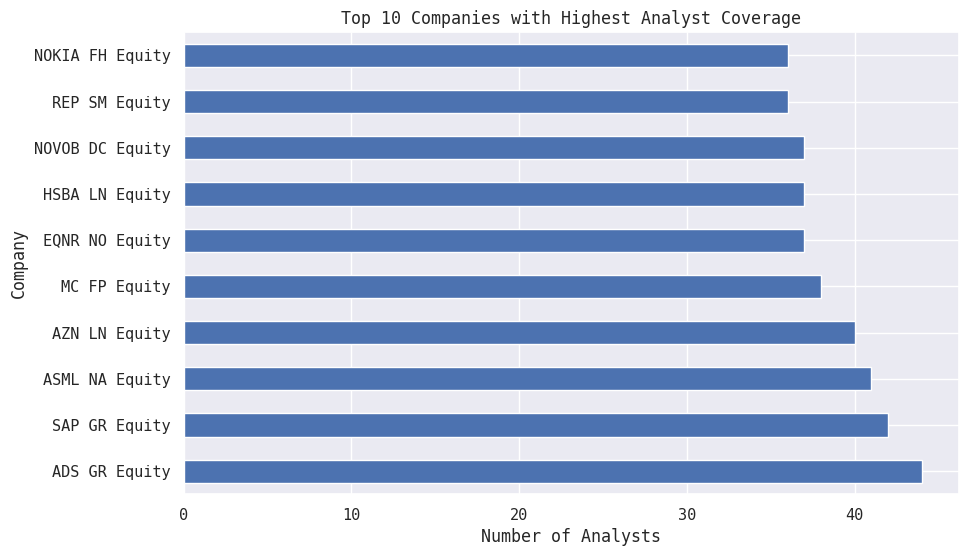

In [101]:
# Calculate the analyst coverage for each company
df_coverage = df_clean[['BBTICKER', 'ANALYST']].copy()
df_coverage = df_coverage.drop_duplicates()
company_coverage = df_coverage['BBTICKER'].value_counts()

# Plot the top 10 companies with the highest analyst coverage
top_10_company_coverage = company_coverage.head(10)

plt.figure(figsize=(10, 6))
top_10_company_coverage.plot(kind='barh')
plt.title('Top 10 Companies with Highest Analyst Coverage')
plt.ylabel('Company')
plt.xlabel('Number of Analysts')
plt.show()

In [102]:
# Find the company with the highest analyst coverage
most_covered_company = company_coverage.idxmax()
most_covered_company_coverage = company_coverage.max()

print(f"The company with the highest analyst coverage is '{most_covered_company}' with {most_covered_company_coverage} analysts covering it.")

The company with the highest analyst coverage is 'ADS GR Equity' with 44 analysts covering it.


## 2. Which analyst covers the most companies?

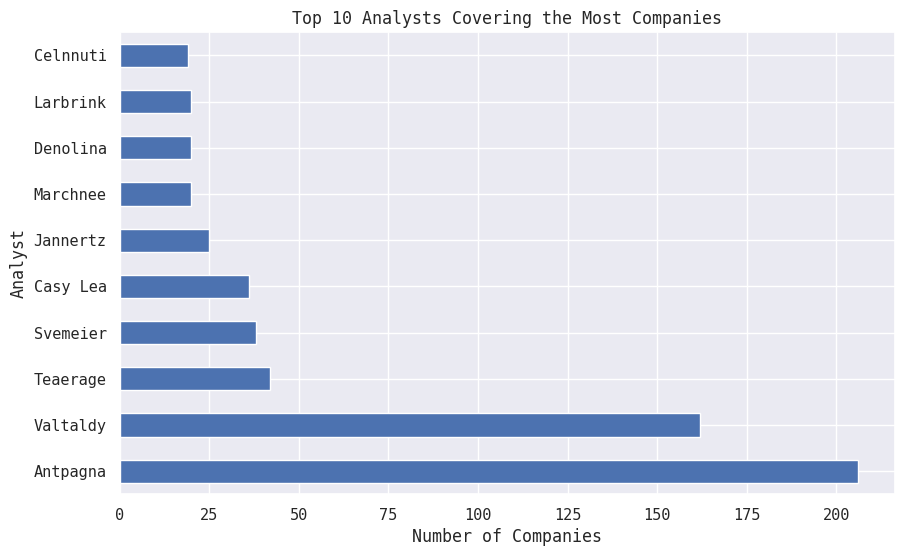

In [103]:
# Calculate the number of companies each analyst covers
# analyst_coverage = df.groupby('ANALYST')['BBTICKER'].nunique()
analyst_coverage = df_coverage['ANALYST'].value_counts()

# Plot the top 10 analysts covering the most companies
# top_10_analyst_coverage = analyst_coverage.sort_values(ascending=False).head(10)
top_10_analyst_coverage = analyst_coverage.head(10)

plt.figure(figsize=(10, 6))
top_10_analyst_coverage.plot(kind='barh')

plt.title('Top 10 Analysts Covering the Most Companies')
plt.ylabel('Analyst')
plt.xlabel('Number of Companies')
plt.show()

In [104]:
# Find the analyst covering the most companies
most_companies_analyst = analyst_coverage.idxmax()
most_companies_coverage = analyst_coverage.max()

print(f"The analyst who covers the most companies is '{most_companies_analyst}' covering {most_companies_coverage} different companies.")

The analyst who covers the most companies is 'Antpagna' covering 206 different companies.


## 3. Similarity Matrix

### 3a. Based on how analysts organize themselves into covering companies, could you model the similarity or conversely, the distance matrix between the companies based on this analyst co-coverage


Shape of the similarity matrix: (206, 206)


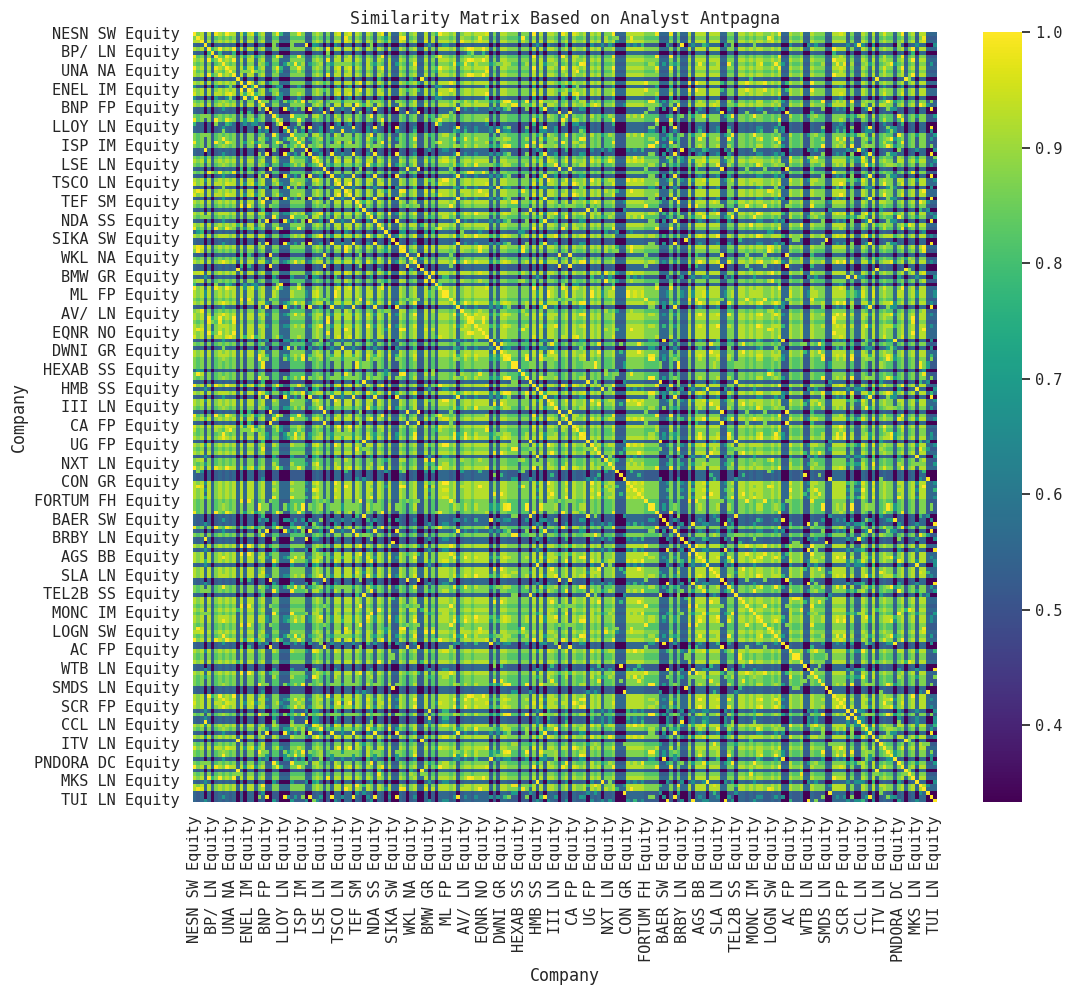

In [167]:
categorical_features_ordinal = []
categorical_features_one_hot = ['GICS_SECTOR_NAME', 'GICS_INDUSTRY_GROUP_NAME', 'BROKER']
numerical_features = ['RATING']
clean_pipeline = get_pipeline_clean_encode_only(categorical_features_one_hot, categorical_features_ordinal, numerical_features)

# Dataset for analyst Antpagna with removed duplicates
df_analyst_antpagna = df_clean[df_clean["ANALYST"] == "Antpagna"].drop_duplicates(subset=['BBTICKER']).reset_index(drop=True)

# Similarity matrix for Antpagna
df_preprocessed_antpagna = clean_pipeline.fit_transform(df_analyst_antpagna.copy())
df_analyst_antpagna_cols = df_analyst_antpagna["BBTICKER"].tolist().copy()
df_preprocessed_antpagna_sim = pd.DataFrame(data = cosine_similarity(df_preprocessed_antpagna, df_preprocessed_antpagna),  index = df_analyst_antpagna_cols, columns = df_analyst_antpagna_cols)

print("Shape of the similarity matrix:", df_preprocessed_antpagna_sim.shape)

plt.figure(figsize=(12, 10))
sns.heatmap(df_preprocessed_antpagna_sim, cmap='viridis')
plt.title('Similarity Matrix Based on Analyst Antpagna')
plt.xlabel('Company')
plt.ylabel('Company')
plt.show()

Companies covered by Anpagna seem to be similar to each other based on cosine similarity (>85% score), with a few exceptions.  
MC FP Equity is an example of a company different from all others.  
In general, companies that differ from the rest have low cosine similarity with all other companies.

Shape of the distance matrix: (206, 206)


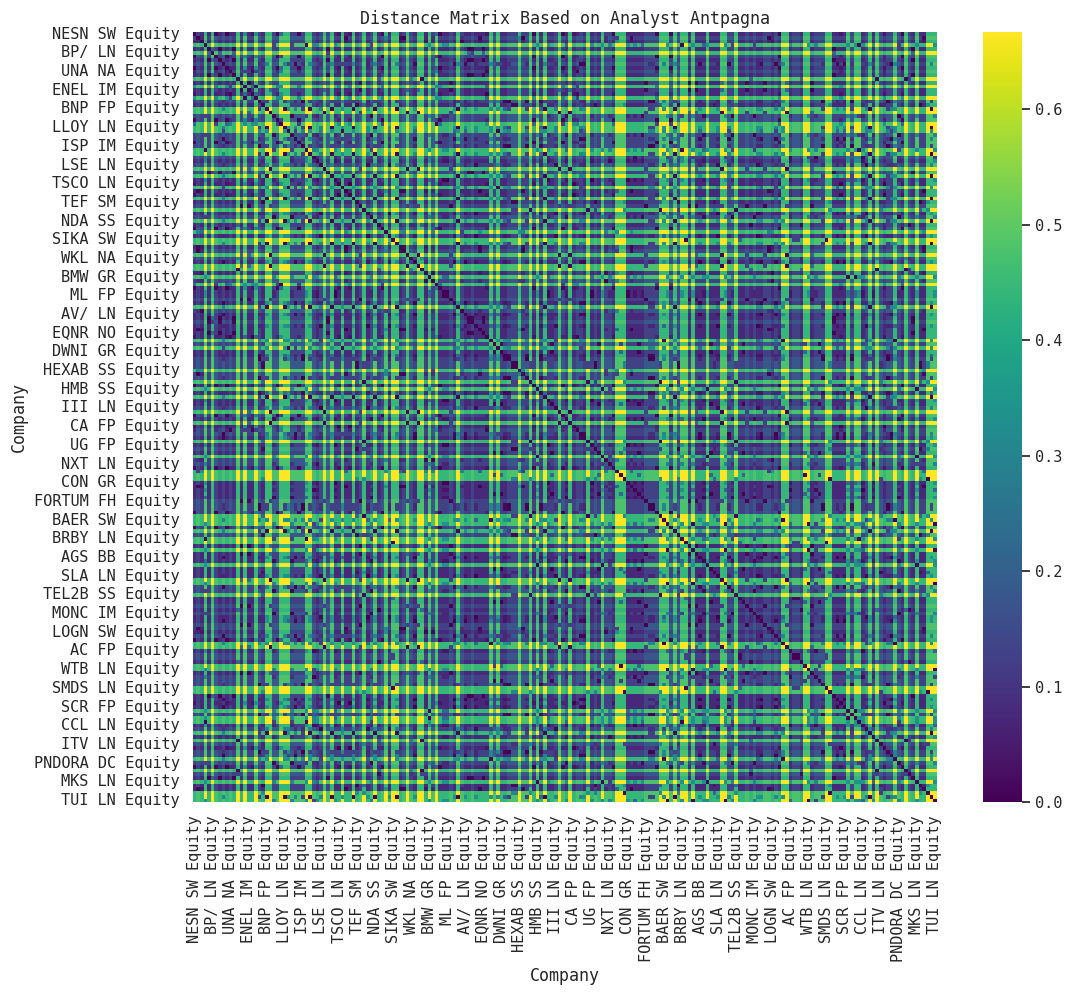

In [168]:
# Distance matrix for Antpaga
df_preprocessed_antpagna_dist = 1 - df_preprocessed_antpagna_sim

print("Shape of the distance matrix:", df_preprocessed_antpagna_dist.shape)

plt.figure(figsize=(12, 10))
sns.heatmap(df_preprocessed_antpagna_dist, cmap='viridis')
plt.title('Distance Matrix Based on Analyst Antpagna')
plt.xlabel('Company')
plt.ylabel('Company')
plt.show()

### 3b. How would the results change if you were to restrict the dataset to only analysts having companies covered within 1s.d. of the distribution found in Qn. 2?

Shape of the similarity matrix: (360, 360)


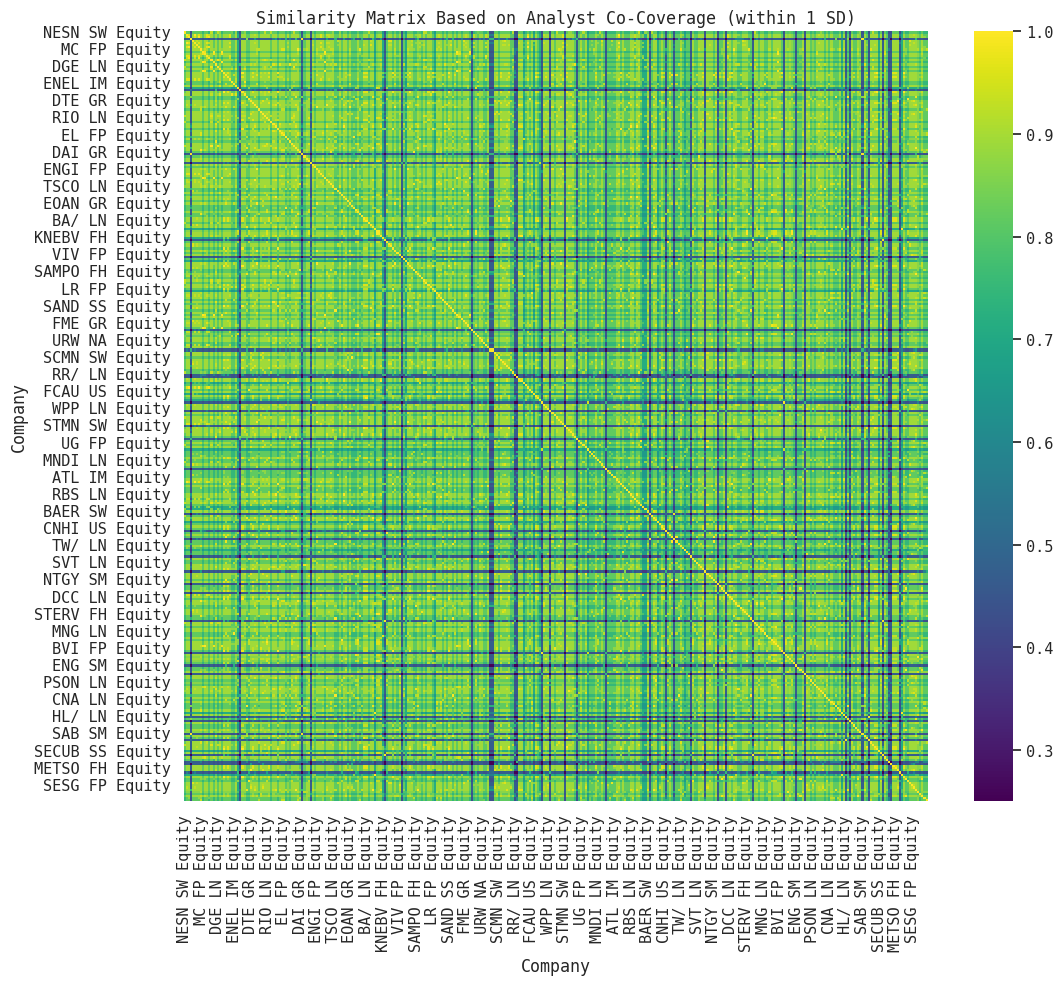

In [110]:
# Calculate the mean and standard deviation of the number of companies covered by each analyst
mean_coverage = analyst_coverage.mean()
std_dev_coverage = analyst_coverage.std()

# Filter analysts who cover companies within 1 standard deviation of the mean
filtered_analysts = analyst_coverage[(analyst_coverage >= mean_coverage - std_dev_coverage) &
                                     (analyst_coverage <= mean_coverage + std_dev_coverage)].index
df_filtered = df_clean[df_clean['ANALYST'].isin(filtered_analysts)].drop_duplicates(subset=['BBTICKER']).reset_index(drop=True)

# Similarity matrix based on analyst co coverage (within 1 SD)
df_preprocessed_filtered = clean_pipeline.fit_transform(df_filtered)
df_filtered_cols = df_filtered["BBTICKER"].tolist()
df_preprocessed_filtered_sim = pd.DataFrame(data = cosine_similarity(df_preprocessed_filtered, df_preprocessed_filtered), index = df_filtered_cols, columns = df_filtered_cols)

print("Shape of the similarity matrix:", df_preprocessed_filtered_sim.shape)

plt.figure(figsize=(12, 10))
sns.heatmap(df_preprocessed_filtered_sim, cmap='viridis')
plt.title('Similarity Matrix Based on Analyst Co-Coverage (within 1 SD)' )
plt.xlabel('Company')
plt.ylabel('Company')
plt.show()


1974 analysts remain after the filter.  
Companies covered seem to be generally similar to each other based on cosine similarity (>85% score), to a larger extent than analyst Antpagna.  
From this, we can understand that analyst Antpagna generally covers a wider variety of companies than most analysts.  


Shape of the distance matrix: (360, 360)


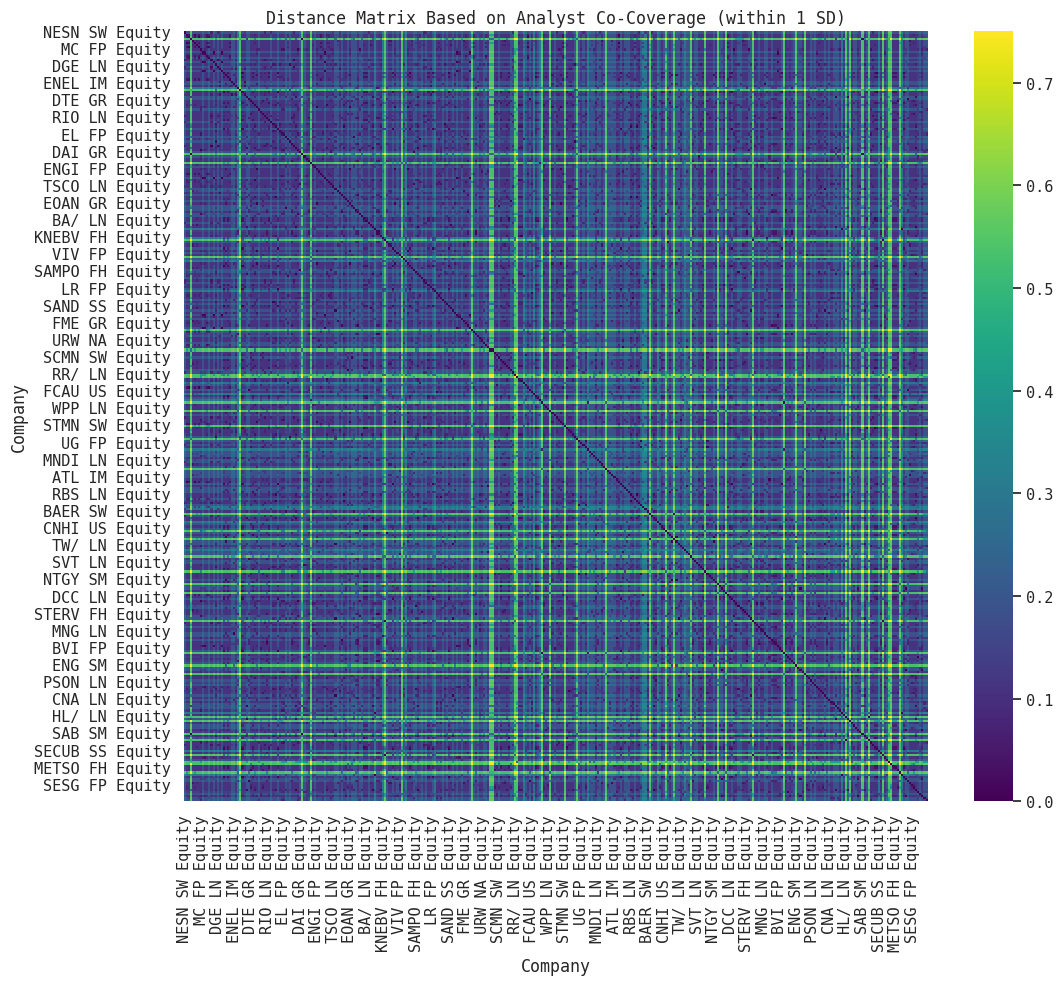

In [111]:
# Distance matrix based on analyst co coverage (within 1 SD)
df_preprocessed_filtered_dist = 1 - df_preprocessed_filtered_sim

print("Shape of the distance matrix:", df_preprocessed_filtered_dist.shape)

plt.figure(figsize=(12, 10))
sns.heatmap(df_preprocessed_filtered_dist, cmap='viridis')
plt.title('Distance Matrix Based on Analyst Co-Coverage (within 1 SD)')
plt.xlabel('Company')
plt.ylabel('Company')
plt.show()

### 3c. If further restricted to a smaller subset?

We take a random sample of 10 analysts that covered the median number of companies

Shape of the similarity matrix: (30, 30)


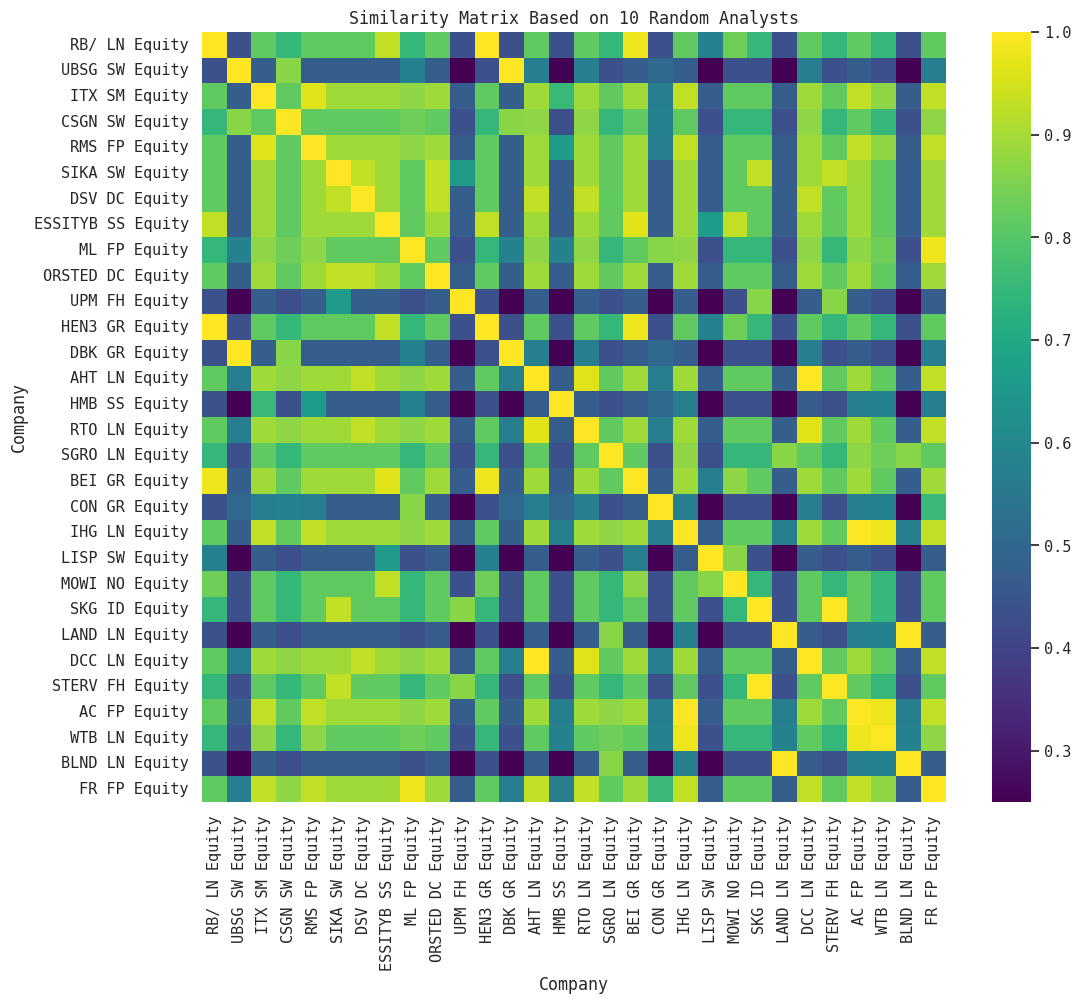

In [115]:
# Calculate the median of the number of companies covered by each analyst
median_coverage = analyst_coverage.median()

# Filter 10 random analysts who cover the median number of companies
filtered_analysts2 = analyst_coverage[(analyst_coverage == median_coverage)].sample(10).index
df_filtered2 = df_clean[df_clean['ANALYST'].isin(filtered_analysts2)].drop_duplicates(subset=['BBTICKER']).reset_index(drop=True)

# Similarity matrix based on 10 random analysts who cover the median number of companies
df_preprocessed_filtered2 = clean_pipeline.fit_transform(df_filtered2)
df_filtered_cols2 = df_filtered2["BBTICKER"].tolist()
df_preprocessed_filtered_sim2 = pd.DataFrame(data = cosine_similarity(df_preprocessed_filtered2, df_preprocessed_filtered2), index = df_filtered_cols2, columns = df_filtered_cols2)

print("Shape of the similarity matrix:", df_preprocessed_filtered_sim2.shape)

plt.figure(figsize=(12, 10))
sns.heatmap(df_preprocessed_filtered_sim2, cmap='viridis')
plt.title('Similarity Matrix Based on 10 Random Analysts' )
plt.xlabel('Company')
plt.ylabel('Company')
plt.show()

We ran this test a few times, and observed that the similarity matrix does not change much.  
Most companies are similar to each other based on cosine similarity, with the exception of XXX.

Shape of the distance matrix: (30, 30)


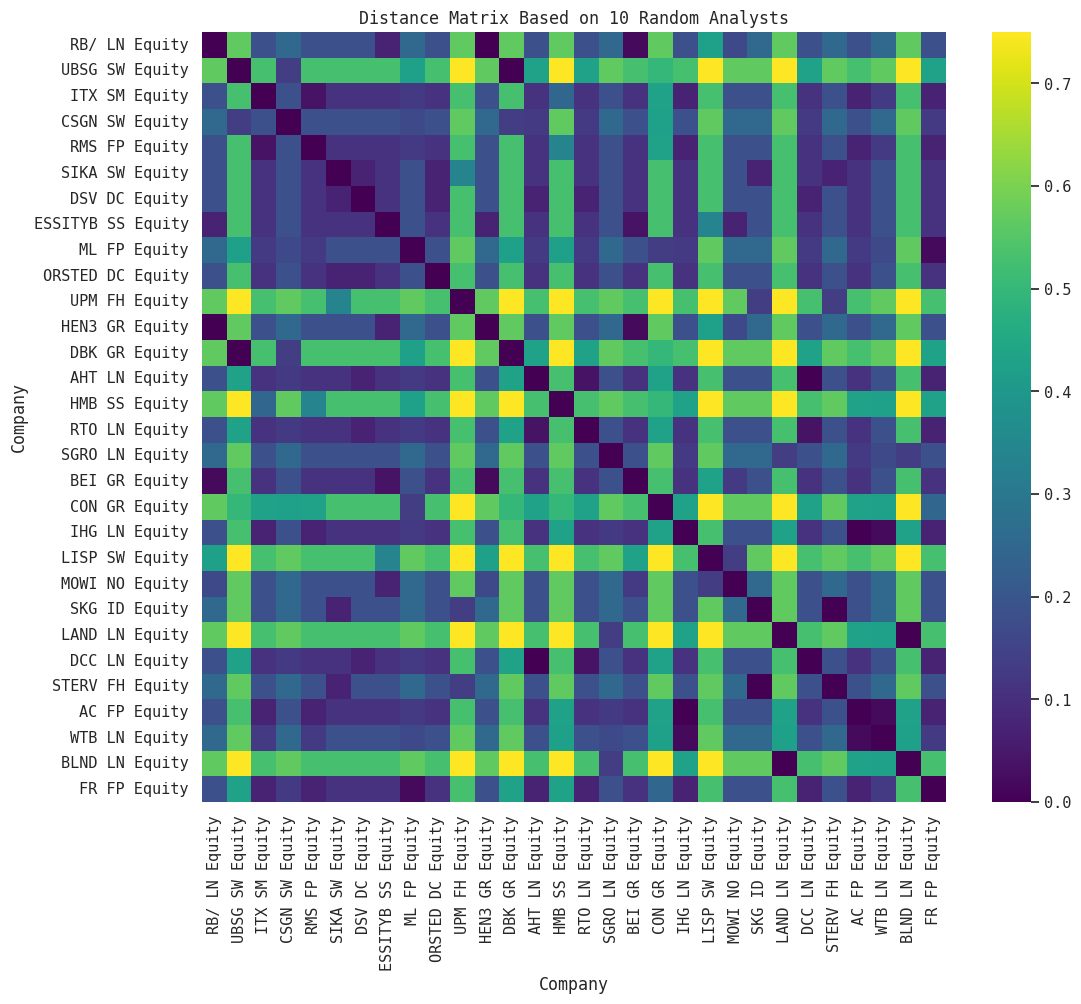

In [116]:
# Distance matrix based on 10 random analysts who cover the median number of companies
df_preprocessed_filtered_dist2 = 1 - df_preprocessed_filtered_sim2

print("Shape of the distance matrix:", df_preprocessed_filtered_dist2.shape)

plt.figure(figsize=(12, 10))
sns.heatmap(df_preprocessed_filtered_dist2, cmap='viridis')
plt.title('Distance Matrix Based on 10 Random Analysts')
plt.xlabel('Company')
plt.ylabel('Company')
plt.show()

# 4/5/6. Which sectors are the most heterogenous? Which sectors are the most homogenous? What type of companies tend to be outliers in terms of the clusters?
(Look at the clusters formed by industry groups per sector – use t-SNE to visualize)

## 4/5/6a. Using similarity matrix based on analyst with highest coverage

Number of clusters in level 1: 11
Number of clusters in level 2: 24


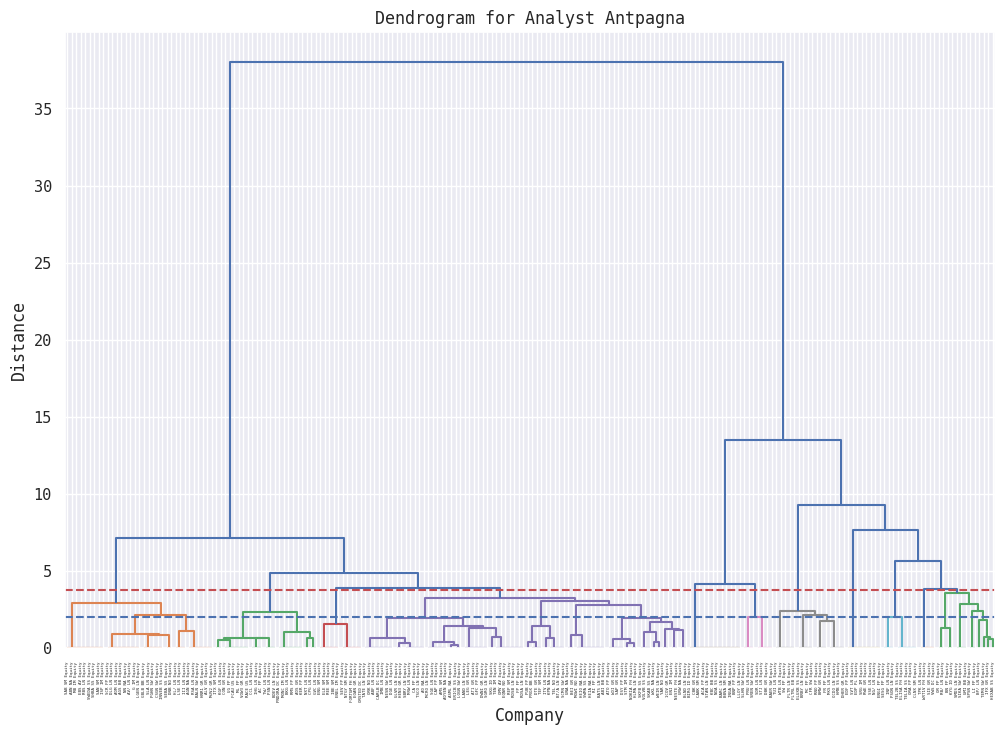

In [169]:
# Hierarchical Clustering for Antpagna based on Distance Matrix in 3a
antpagna_link = linkage(df_preprocessed_antpagna_dist, method='ward')

# Set two thresholds so depth of division mimicks GICS (11 and 24 clusters)
threshold1 = 3.8
threshold2 = 2
clusters1 = fcluster(antpagna_link, threshold1, criterion='distance')
clusters2 = fcluster(antpagna_link, threshold2, criterion='distance')
df_analyst_antpagna['CLUSTER_1'] = clusters1
df_analyst_antpagna['CLUSTER_2'] = clusters2

print(f"Number of clusters in level 1: {df_analyst_antpagna['CLUSTER_1'].nunique()}")
print(f"Number of clusters in level 2: {df_analyst_antpagna['CLUSTER_2'].nunique()}")

# Dendrogram for Hierarchical Clustering
plt.figure(figsize=(12, 8))
dendrogram(antpagna_link, labels=df_analyst_antpagna_cols, leaf_rotation=90, leaf_font_size=3, color_threshold=max(threshold1, threshold2))
plt.title('Dendrogram for Analyst Antpagna')
plt.xlabel('Company')
plt.ylabel('Distance')
plt.axhline(y=threshold1, color='r', linestyle='--', label=f'Threshold 1: {threshold1}')
plt.axhline(y=threshold2, color='b', linestyle='--', label=f'Threshold 2: {threshold2}')
plt.show()

In [170]:
# Analysis of Hierarchical Clustering

# Calculate silhouette score
silhouette_avg = silhouette_score(df_preprocessed_antpagna, clusters2)
print(f"Silhouette Score: {silhouette_avg}")

# Cluster composition
df_analyst_antpagna_sorted = df_analyst_antpagna.sort_values(by=['CLUSTER_1', 'CLUSTER_2']).copy()
df_analyst_antpagna_sorted['COMBINED_CLUSTERS'] = df_analyst_antpagna_sorted['CLUSTER_1'].astype(str) + '-' + df_analyst_antpagna_sorted['CLUSTER_2'].astype(str)
df_cluster = df_analyst_antpagna_sorted.groupby('COMBINED_CLUSTERS').agg(
    NUMBER_OF_COMPANIES=('BBTICKER', 'count'),
    MODE_GICS_SECTOR_NAME=('GICS_SECTOR_NAME', lambda x: x.mode()[0] if not x.mode().empty else np.nan),
    MODE_GICS_INDUSTRY_GROUP_NAME=('GICS_INDUSTRY_GROUP_NAME', lambda x: x.mode()[0] if not x.mode().empty else np.nan),
    MEAN_RATING=('RATING', 'mean'),
    MEAN_TARGET_PRICE=('TARGET_PRICE', 'mean')
).reset_index()

# Sort the combined cluster composition table
df_cluster_sorted = df_cluster['COMBINED_CLUSTERS'].str.split('-', expand=True).astype(int)
df_cluster['CLUSTER_1'] = df_cluster_sorted[0]
df_cluster['CLUSTER_2'] = df_cluster_sorted[1]
df_cluster.sort_values(by=['CLUSTER_1', 'CLUSTER_2'], inplace=True)
df_cluster.drop(columns=['CLUSTER_1', 'CLUSTER_2'], inplace=True)
df_cluster.reset_index(drop=True, inplace=True)

df_cluster

Silhouette Score: 0.542700195226372


,COMBINED_CLUSTERS,NUMBER_OF_COMPANIES,MODE_GICS_SECTOR_NAME,MODE_GICS_INDUSTRY_GROUP_NAME,MEAN_RATING,MEAN_TARGET_PRICE
0,1-1,9,Financials,Banks,3.000000,-2.420000e-14
1,1-2,15,Financials,Insurance,5.000000,-2.420000e-14
2,1-3,9,Financials,Insurance,3.000000,-2.420000e-14
3,2-4,14,Consumer Discretionary,Automobiles & Components,5.000000,-2.420000e-14
4,2-5,9,Consumer Discretionary,Consumer Durables & Apparel,3.000000,-2.420000e-14
5,3-6,10,Utilities,Utilities,4.000000,-2.420000e-14
6,4-7,36,Consumer Staples,Energy,5.000000,-2.420000e-14
7,4-8,9,Communication Services,Telecommunication Services,3.888889,-2.420000e-14
8,4-9,9,Consumer Staples,"Food, Beverage & Tobacco",3.000000,-2.420000e-14
9,4-10,18,Information Technology,Capital Goods,3.333333,-2.420000e-14


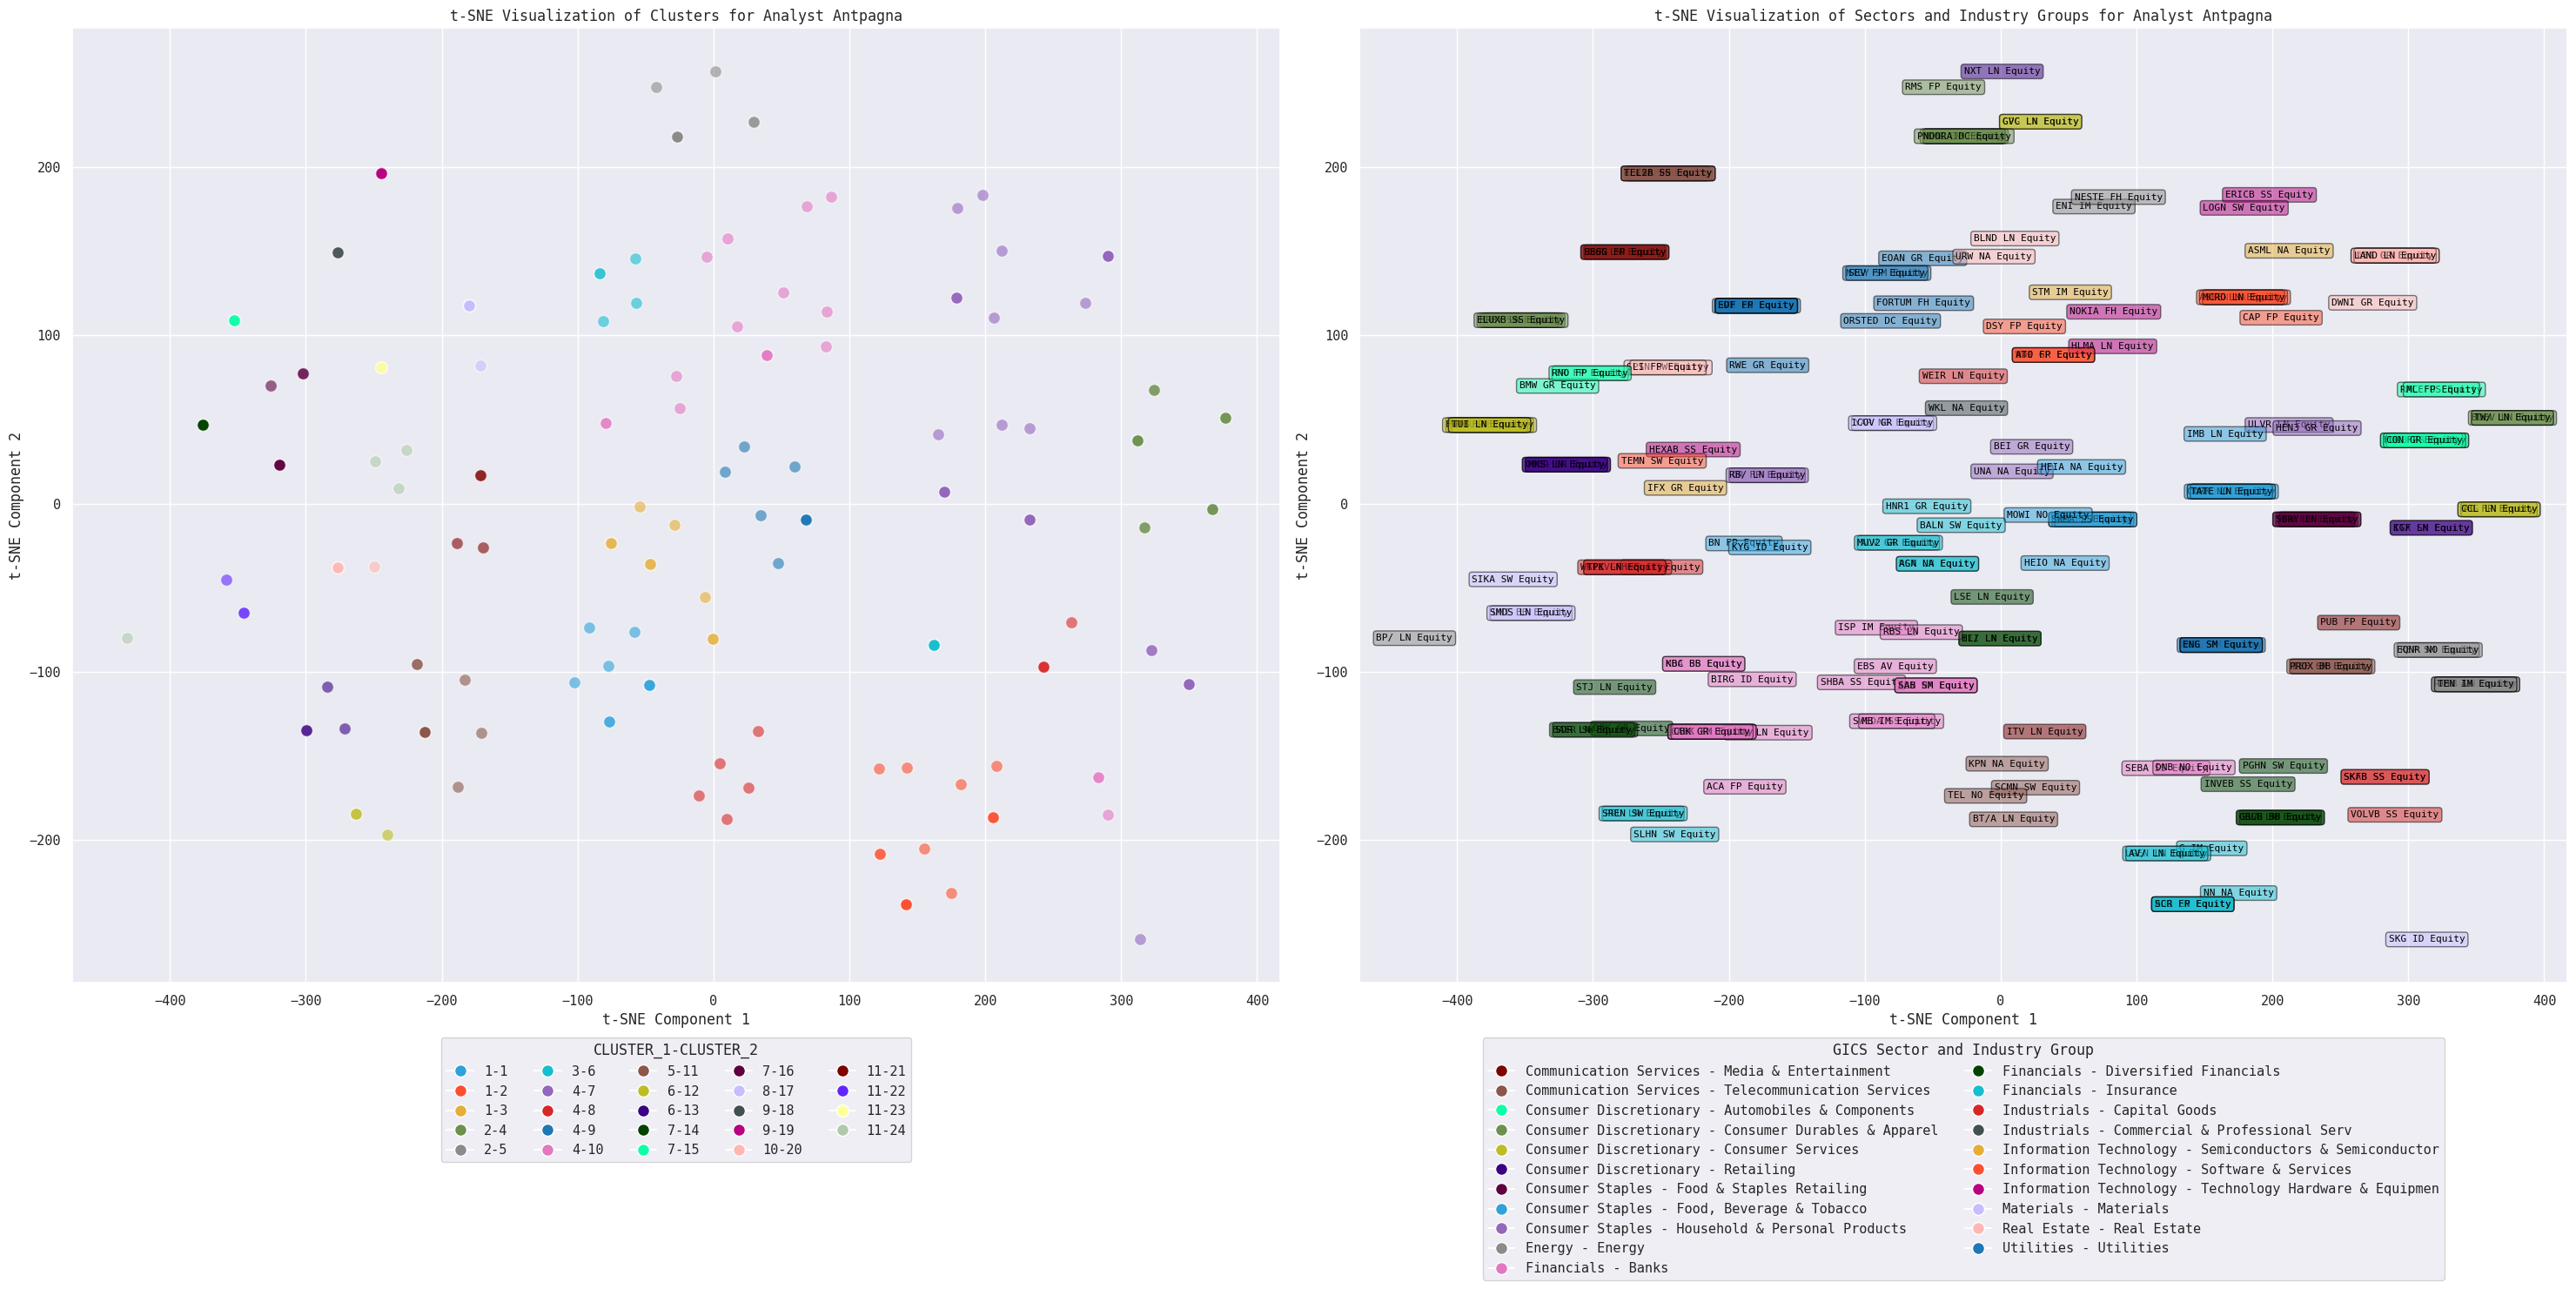

In [173]:
# Perform t-SNE
tsne = TSNE(n_components=2, random_state=RANDOM_STATE)
tsne_results = tsne.fit_transform(df_preprocessed_antpagna)

# Create a new DataFrame for the t-SNE results with cluster and sector information
df_tsne = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
df_tsne['CLUSTER_1'] = df_analyst_antpagna['CLUSTER_1']
df_tsne['CLUSTER_2'] = df_analyst_antpagna['CLUSTER_2']
df_tsne['COMBINED_CLASTER'] = df_tsne['CLUSTER_1'].astype(str) + "-" + df_tsne['CLUSTER_2'].astype(str)
df_tsne['GICS_SECTOR_NAME'] = df_analyst_antpagna['GICS_SECTOR_NAME']
df_tsne['GICS_INDUSTRY_GROUP_NAME'] = df_analyst_antpagna['GICS_INDUSTRY_GROUP_NAME']
df_tsne['COMPANY'] = df_analyst_antpagna['BBTICKER']

fig, axes = plt.subplots(1, 2, figsize=(30, 15))

# Plot t-SNE by combined clusters
combined_colormap_clusters = plt.get_cmap("cet_glasbey_hv")
unique_combinations_clusters = df_tsne[['CLUSTER_1', 'CLUSTER_2']].drop_duplicates().sort_values(by=['CLUSTER_1', 'CLUSTER_2'])
color_map_combined_clusters = {tuple(comb): combined_colormap_clusters(i) for i, comb in enumerate(unique_combinations_clusters.itertuples(index=False, name=None))}

for i in range(df_tsne.shape[0]):
    cluster_comb = (df_tsne['CLUSTER_1'].iloc[i], df_tsne['CLUSTER_2'].iloc[i])
    axes[0].scatter(
        df_tsne.TSNE1.iloc[i],
        df_tsne.TSNE2.iloc[i],
        color=color_map_combined_clusters[cluster_comb],
        s=100,
        edgecolor='w',
        alpha=0.6
    )

handles_combined_clusters = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map_combined_clusters[comb], markersize=10, label=f'{comb[0]}-{comb[1]}') for comb in sorted(color_map_combined_clusters.keys())]
axes[0].legend(handles=handles_combined_clusters, title='CLUSTER_1-CLUSTER_2', loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=5)

axes[0].set_title('t-SNE Visualization of Clusters for Analyst Antpagna')
axes[0].set_xlabel('t-SNE Component 1')
axes[0].set_ylabel('t-SNE Component 2')

# Plot t-SNE by GICS sectors and industry groups
combined_colormap = plt.get_cmap("cet_glasbey_hv")
unique_combinations = df_tsne[['GICS_SECTOR_NAME', 'GICS_INDUSTRY_GROUP_NAME']].drop_duplicates()
color_map_combined = {tuple(comb): combined_colormap(i) for i, comb in enumerate(unique_combinations.itertuples(index=False, name=None))}

for i in range(df_tsne.shape[0]):
    sector_industry_comb = (df_tsne['GICS_SECTOR_NAME'].iloc[i], df_tsne['GICS_INDUSTRY_GROUP_NAME'].iloc[i])
    axes[1].text(
        df_tsne.TSNE1.iloc[i],
        df_tsne.TSNE2.iloc[i],
        df_tsne.COMPANY.iloc[i],
        horizontalalignment='center',
        verticalalignment='center',
        size=8,
        color='black',
        bbox=dict(facecolor=color_map_combined[sector_industry_comb], alpha=0.5, boxstyle='round,pad=0.3', edgecolor='black')
    )

# Create the legend for sectors and industry groups
sorted_color_map_combined = dict(sorted(color_map_combined.items(), key=lambda item: item[0]))
handles_combined = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=sorted_color_map_combined[comb], markersize=10, label=f'{comb[0]} - {comb[1]}') for comb in sorted_color_map_combined]
axes[1].legend(handles=handles_combined, title='GICS Sector and Industry Group', loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)

axes[1].scatter(df_tsne['TSNE1'], df_tsne['TSNE2'], alpha=0.0)
axes[1].set_title('t-SNE Visualization of Sectors and Industry Groups for Analyst Antpagna')
axes[1].set_xlabel('t-SNE Component 1')
axes[1].set_ylabel('t-SNE Component 2')

plt.tight_layout()
plt.show()

For companies analysed by Analyst Antpagna, sectors Communication Services, and Financials are most heterogenous (sectors spread across multiple clusters), and sectors Consumer Staples and Utilities are most homogenous (sectors more clustered together). Companies SKG ID Equity from sector Materials and BP/LN Equity from sector Energy appear to be an outliers.

## 4/5/6b. Using similarity matrix based on analyst co-coverage (within 1 SD)

Number of clusters in level 1: 11
Number of clusters in level 2: 24


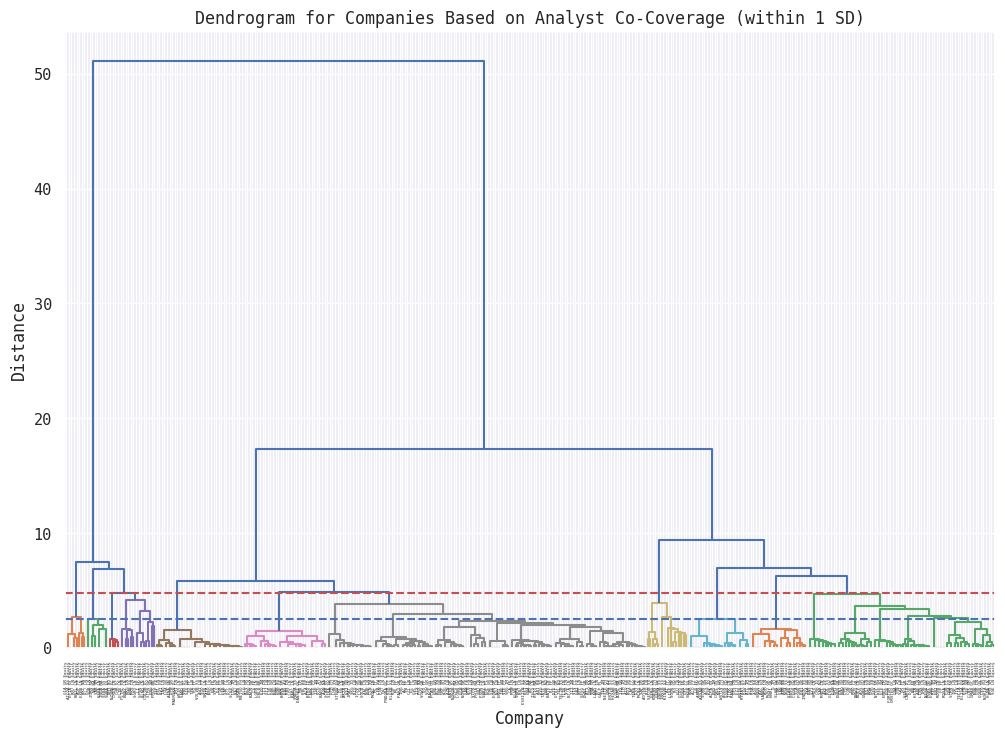

In [200]:
# Hierarchical Clustering for Antpagna based on Distance Matrix in 3b
filtered_link = linkage(df_preprocessed_filtered_dist, method='ward')

# Set two thresholds so depth of division mimicks GICS (11 and 24 clusters)
threshold1 = 4.75
threshold2 = 2.465
clusters1 = fcluster(filtered_link, threshold1, criterion='distance')
clusters2 = fcluster(filtered_link, threshold2, criterion='distance')
df_filtered['CLUSTER_1'] = clusters1
df_filtered['CLUSTER_2'] = clusters2

print(f"Number of clusters in level 1: {df_filtered['CLUSTER_1'].nunique()}")
print(f"Number of clusters in level 2: {df_filtered['CLUSTER_2'].nunique()}")

# Dendrogram for Hierarchical Clustering
plt.figure(figsize=(12, 8))
dendrogram(filtered_link, labels=df_filtered_cols, leaf_rotation=90, leaf_font_size=3, color_threshold=max(threshold1, threshold2))
plt.title('Dendrogram for Companies Based on Analyst Co-Coverage (within 1 SD)')
plt.xlabel('Company')
plt.ylabel('Distance')
plt.axhline(y=threshold1, color='r', linestyle='--', label=f'Threshold 1: {threshold1}')
plt.axhline(y=threshold2, color='b', linestyle='--', label=f'Threshold 2: {threshold2}')
plt.show()

In [205]:
# Analysis of Hierarchical Clustering

# Calculate silhouette score
silhouette_avg = silhouette_score(df_preprocessed_filtered, clusters2)
print(f"Silhouette Score: {silhouette_avg}")

# Cluster composition
df_filtered_sorted = df_filtered.sort_values(by=['CLUSTER_1', 'CLUSTER_2']).copy()
df_filtered_sorted['COMBINED_CLUSTERS'] = df_filtered_sorted['CLUSTER_1'].astype(str) + '-' + df_filtered_sorted['CLUSTER_2'].astype(str)
df_cluster = df_filtered_sorted.groupby('COMBINED_CLUSTERS').agg(
    NUMBER_OF_COMPANIES=('BBTICKER', 'count'),
    MODE_GICS_SECTOR_NAME=('GICS_SECTOR_NAME', lambda x: x.mode()[0] if not x.mode().empty else np.nan),
    MODE_GICS_INDUSTRY_GROUP_NAME=('GICS_INDUSTRY_GROUP_NAME', lambda x: x.mode()[0] if not x.mode().empty else np.nan),
    MEAN_RATING=('RATING', 'mean'),
    MEAN_TARGET_PRICE=('TARGET_PRICE', 'mean')
).reset_index()

# Sort the combined cluster composition table
df_cluster_sorted = df_cluster['COMBINED_CLUSTERS'].str.split('-', expand=True).astype(int)
df_cluster['CLUSTER_1'] = df_cluster_sorted[0]
df_cluster['CLUSTER_2'] = df_cluster_sorted[1]
df_cluster.sort_values(by=['CLUSTER_1', 'CLUSTER_2'], inplace=True)
df_cluster.drop(columns=['CLUSTER_1', 'CLUSTER_2'], inplace=True)
df_cluster.reset_index(drop=True, inplace=True)

df_cluster

Silhouette Score: 0.23420112284438202


,COMBINED_CLUSTERS,NUMBER_OF_COMPANIES,MODE_GICS_SECTOR_NAME,MODE_GICS_INDUSTRY_GROUP_NAME,MEAN_RATING,MEAN_TARGET_PRICE
0,1-1,5,Industrials,Capital Goods,1.000000,546.100000
1,1-2,3,Industrials,Commercial & Professional Serv,1.000000,852.633333
2,2-3,9,Financials,Banks,1.000000,536.083333
3,3-4,4,Materials,Materials,1.000000,1340.500000
4,4-5,6,Consumer Discretionary,Consumer Durables & Apparel,1.000000,3395.233333
5,4-6,4,Real Estate,Real Estate,1.000000,327.275000
6,4-7,4,Health Care,Health Care Equipment & Servic,1.000000,366.300000
7,5-8,34,Industrials,Capital Goods,5.000000,1277.173235
8,6-9,32,Financials,Banks,5.000000,464.595312
9,7-10,18,Materials,Materials,4.833333,737.888333


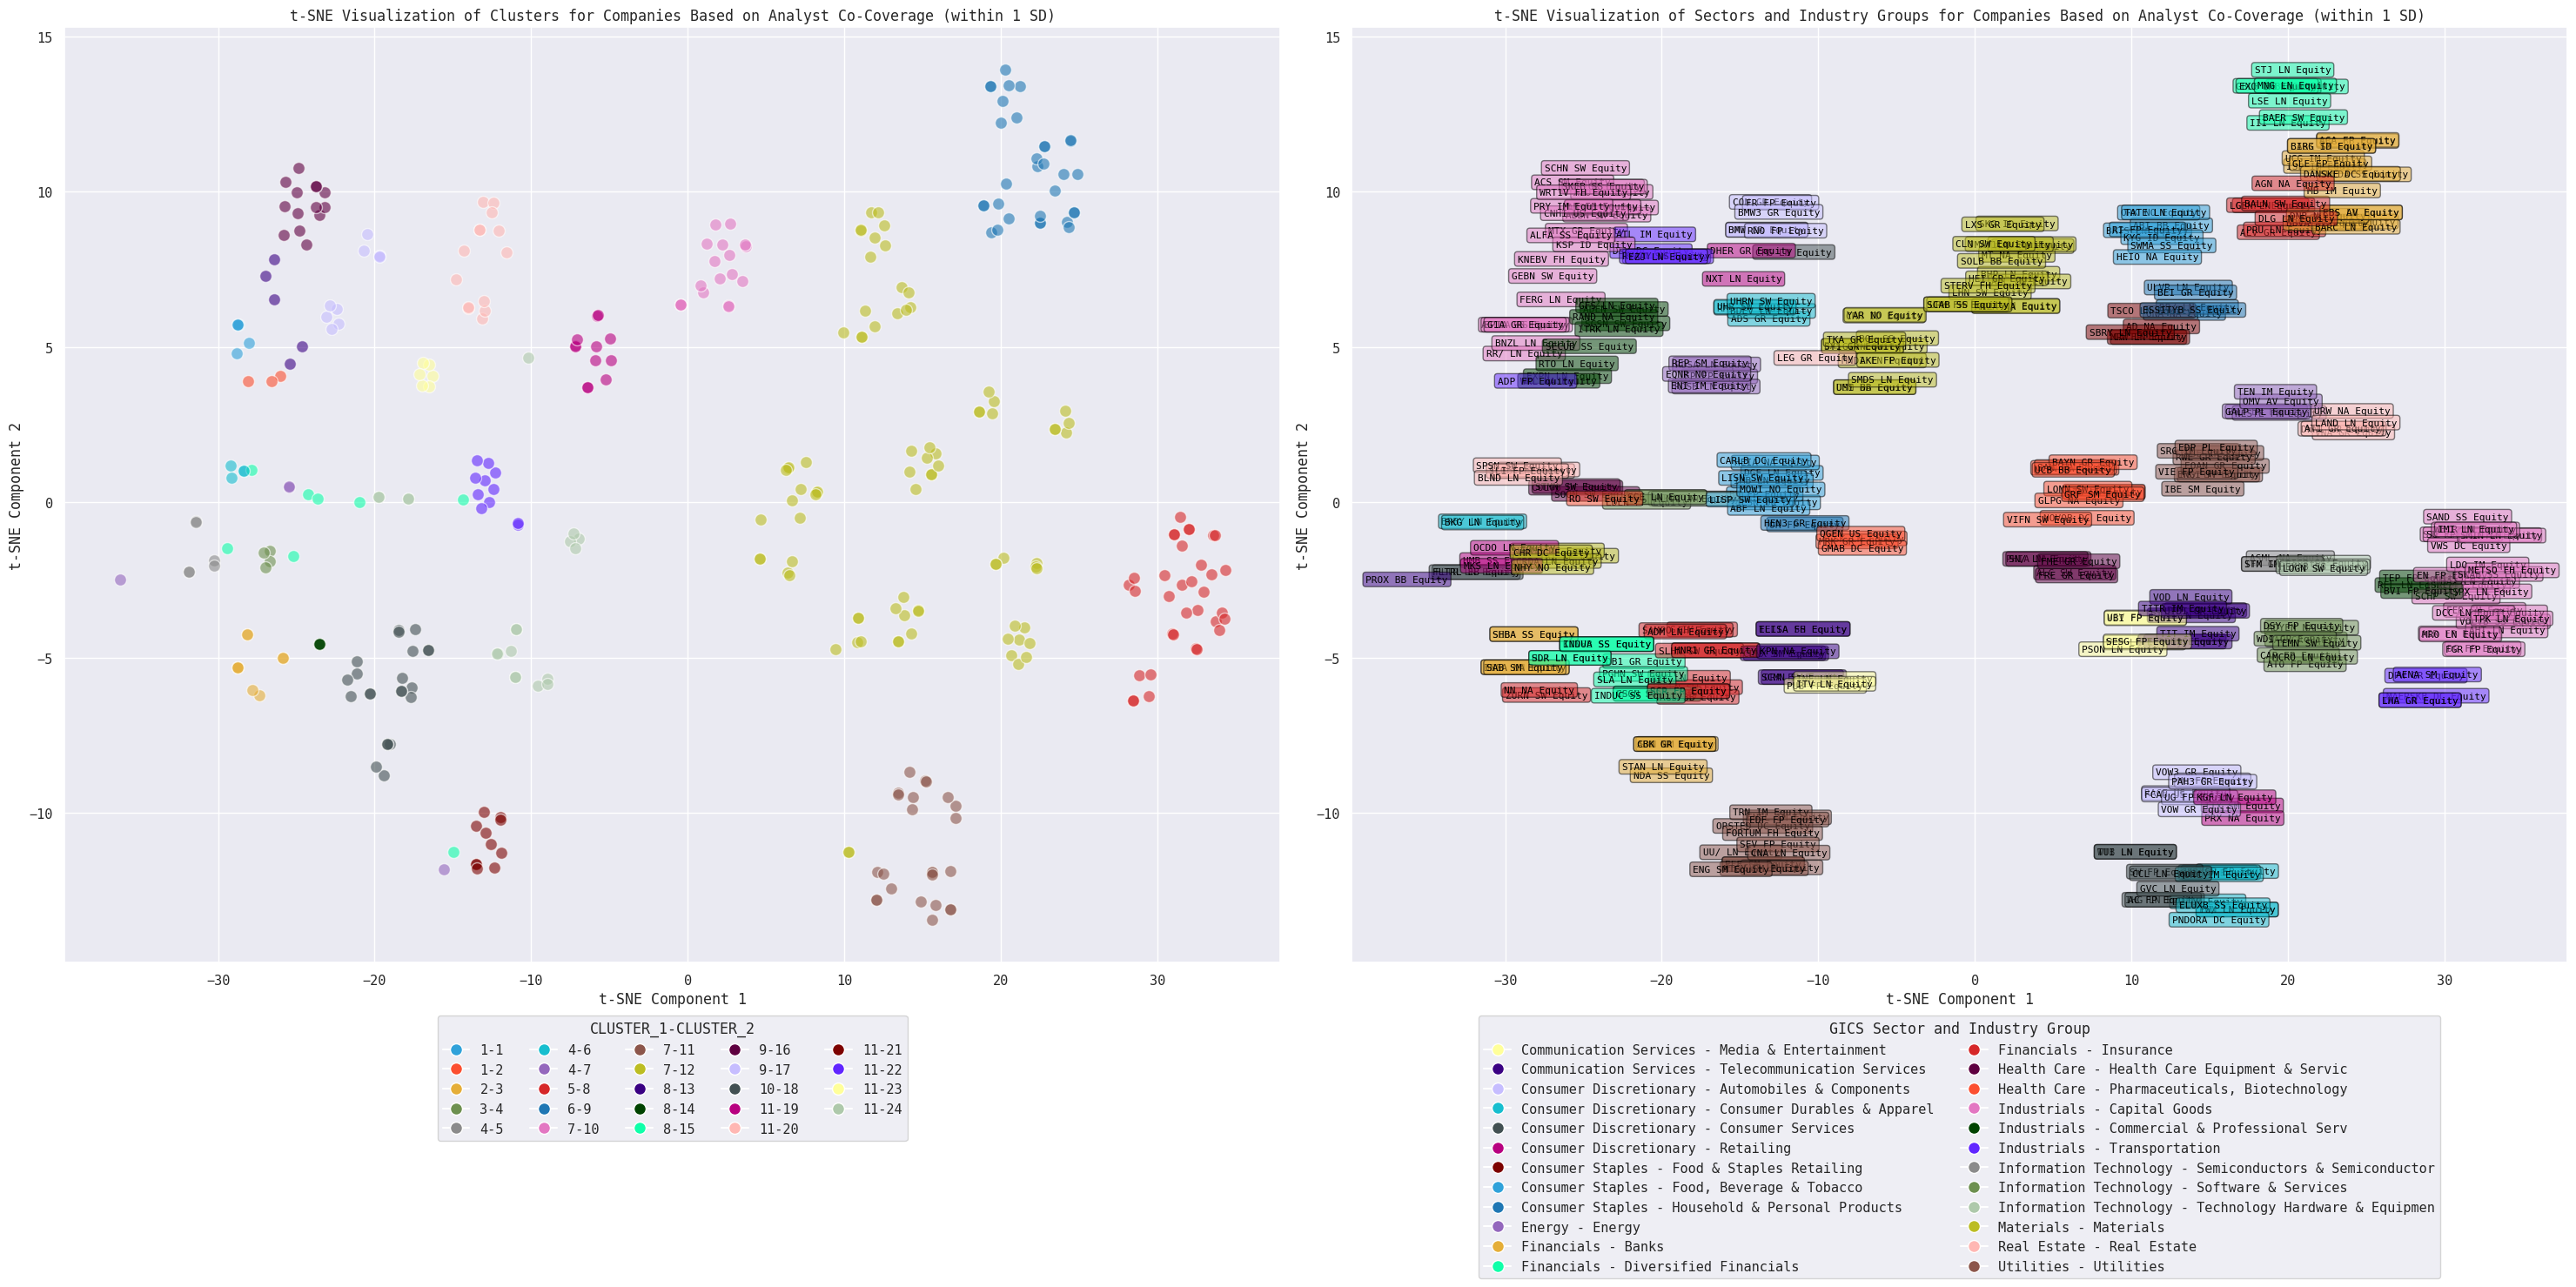

In [207]:
# Perform t-SNE
tsne = TSNE(n_components=2, random_state=RANDOM_STATE)
tsne_results = tsne.fit_transform(df_preprocessed_filtered)

# Create a new DataFrame for the t-SNE results with cluster and sector information
df_tsne = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
df_tsne['CLUSTER_1'] = df_filtered['CLUSTER_1']
df_tsne['CLUSTER_2'] = df_filtered['CLUSTER_2']
df_tsne['COMBINED_CLASTER'] = df_tsne['CLUSTER_1'].astype(str) + "-" + df_tsne['CLUSTER_2'].astype(str)
df_tsne['GICS_SECTOR_NAME'] = df_filtered['GICS_SECTOR_NAME']
df_tsne['GICS_INDUSTRY_GROUP_NAME'] = df_filtered['GICS_INDUSTRY_GROUP_NAME']
df_tsne['COMPANY'] = df_filtered['BBTICKER']

fig, axes = plt.subplots(1, 2, figsize=(30, 15))

# Plot t-SNE by combined clusters
combined_colormap_clusters = plt.get_cmap("cet_glasbey_hv")
unique_combinations_clusters = df_tsne[['CLUSTER_1', 'CLUSTER_2']].drop_duplicates().sort_values(by=['CLUSTER_1', 'CLUSTER_2'])
color_map_combined_clusters = {tuple(comb): combined_colormap_clusters(i) for i, comb in enumerate(unique_combinations_clusters.itertuples(index=False, name=None))}

for i in range(df_tsne.shape[0]):
    cluster_comb = (df_tsne['CLUSTER_1'].iloc[i], df_tsne['CLUSTER_2'].iloc[i])
    axes[0].scatter(
        df_tsne.TSNE1.iloc[i],
        df_tsne.TSNE2.iloc[i],
        color=color_map_combined_clusters[cluster_comb],
        s=100,
        edgecolor='w',
        alpha=0.6
    )

handles_combined_clusters = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map_combined_clusters[comb], markersize=10, label=f'{comb[0]}-{comb[1]}') for comb in sorted(color_map_combined_clusters.keys())]
axes[0].legend(handles=handles_combined_clusters, title='CLUSTER_1-CLUSTER_2', loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=5)

axes[0].set_title('t-SNE Visualization of Clusters for Companies Based on Analyst Co-Coverage (within 1 SD)')
axes[0].set_xlabel('t-SNE Component 1')
axes[0].set_ylabel('t-SNE Component 2')

# Plot t-SNE by GICS sectors and industry groups
combined_colormap = plt.get_cmap("cet_glasbey_hv")
unique_combinations = df_tsne[['GICS_SECTOR_NAME', 'GICS_INDUSTRY_GROUP_NAME']].drop_duplicates()
color_map_combined = {tuple(comb): combined_colormap(i) for i, comb in enumerate(unique_combinations.itertuples(index=False, name=None))}

for i in range(df_tsne.shape[0]):
    sector_industry_comb = (df_tsne['GICS_SECTOR_NAME'].iloc[i], df_tsne['GICS_INDUSTRY_GROUP_NAME'].iloc[i])
    axes[1].text(
        df_tsne.TSNE1.iloc[i],
        df_tsne.TSNE2.iloc[i],
        df_tsne.COMPANY.iloc[i],
        horizontalalignment='center',
        verticalalignment='center',
        size=8,
        color='black',
        bbox=dict(facecolor=color_map_combined[sector_industry_comb], alpha=0.5, boxstyle='round,pad=0.3', edgecolor='black')
    )

# Create the legend for sectors and industry groups
sorted_color_map_combined = dict(sorted(color_map_combined.items(), key=lambda item: item[0]))
handles_combined = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=sorted_color_map_combined[comb], markersize=10, label=f'{comb[0]} - {comb[1]}') for comb in sorted_color_map_combined]
axes[1].legend(handles=handles_combined, title='GICS Sector and Industry Group', loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)

axes[1].scatter(df_tsne['TSNE1'], df_tsne['TSNE2'], alpha=0.0)
axes[1].set_title('t-SNE Visualization of Sectors and Industry Groups for Companies Based on Analyst Co-Coverage (within 1 SD)')
axes[1].set_xlabel('t-SNE Component 1')
axes[1].set_ylabel('t-SNE Component 2')

plt.tight_layout()
plt.show()

For companies based on Analyst Co-Coverage (within 1 SD), sectors Financials, and Industrials are most heterogenous (sectors spread across multiple clusters), and sectors Consumer Discretionary and Materials are most homogenous (sectors more clustered together). Companies PROX BB Equity from sector Energy.

## 4/5/6c. Using similarity matrix based on analyst co-coverage (within 1 SD)

Number of clusters in level 1: 11
Number of clusters in level 2: 24


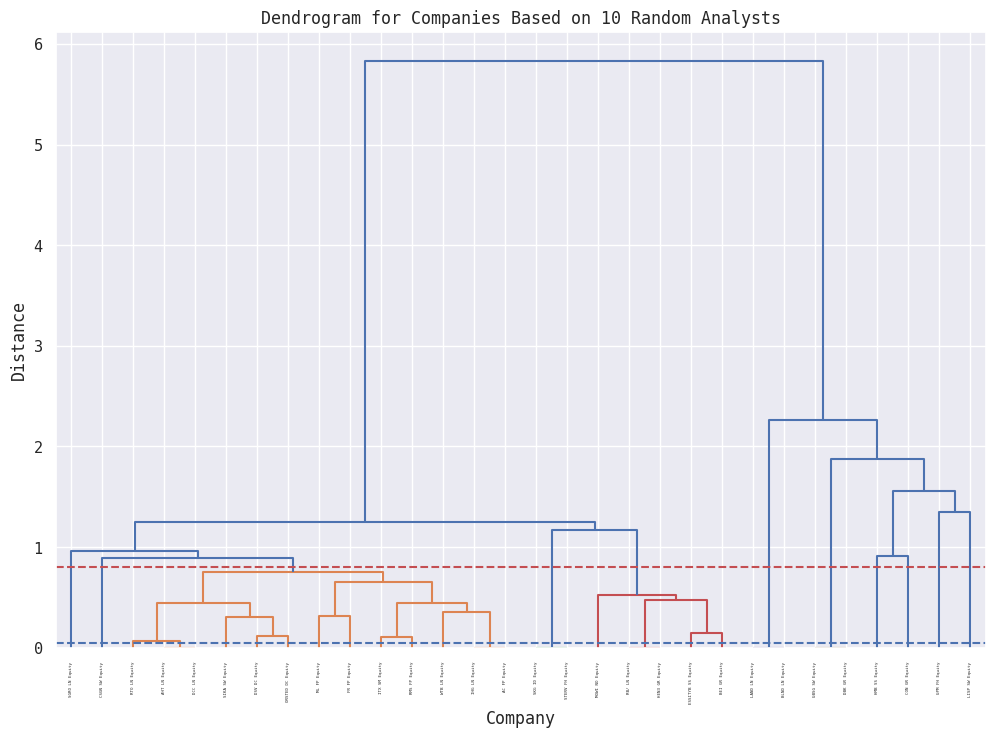

In [216]:
# Hierarchical Clustering for Antpagna based on Distance Matrix in 3b
filtered_link2 = linkage(df_preprocessed_filtered_dist2, method='ward')

# Set two thresholds so depth of division mimicks GICS (11 and 24 clusters)
threshold1 = 0.8
threshold2 = 0.05
clusters1 = fcluster(filtered_link2, threshold1, criterion='distance')
clusters2 = fcluster(filtered_link2, threshold2, criterion='distance')
df_filtered2['CLUSTER_1'] = clusters1
df_filtered2['CLUSTER_2'] = clusters2

print(f"Number of clusters in level 1: {df_filtered2['CLUSTER_1'].nunique()}")
print(f"Number of clusters in level 2: {df_filtered2['CLUSTER_2'].nunique()}")

# Dendrogram for Hierarchical Clustering
plt.figure(figsize=(12, 8))
dendrogram(filtered_link2, labels=df_filtered_cols2, leaf_rotation=90, leaf_font_size=3, color_threshold=max(threshold1, threshold2))
plt.title('Dendrogram for Companies Based on 10 Random Analysts')
plt.xlabel('Company')
plt.ylabel('Distance')
plt.axhline(y=threshold1, color='r', linestyle='--', label=f'Threshold 1: {threshold1}')
plt.axhline(y=threshold2, color='b', linestyle='--', label=f'Threshold 2: {threshold2}')
plt.show()

In [217]:
# Analysis of Hierarchical Clustering

# Calculate silhouette score
silhouette_avg = silhouette_score(df_preprocessed_filtered2, clusters2)
print(f"Silhouette Score: {silhouette_avg}")

# Cluster composition
df_filtered_sorted2 = df_filtered2.sort_values(by=['CLUSTER_1', 'CLUSTER_2']).copy()
df_filtered_sorted2['COMBINED_CLUSTERS'] = df_filtered_sorted2['CLUSTER_1'].astype(str) + '-' + df_filtered_sorted2['CLUSTER_2'].astype(str)
df_cluster = df_filtered_sorted2.groupby('COMBINED_CLUSTERS').agg(
    NUMBER_OF_COMPANIES=('BBTICKER', 'count'),
    MODE_GICS_SECTOR_NAME=('GICS_SECTOR_NAME', lambda x: x.mode()[0] if not x.mode().empty else np.nan),
    MODE_GICS_INDUSTRY_GROUP_NAME=('GICS_INDUSTRY_GROUP_NAME', lambda x: x.mode()[0] if not x.mode().empty else np.nan),
    MEAN_RATING=('RATING', 'mean'),
    MEAN_TARGET_PRICE=('TARGET_PRICE', 'mean')
).reset_index()

# Sort the combined cluster composition table
df_cluster_sorted = df_cluster['COMBINED_CLUSTERS'].str.split('-', expand=True).astype(int)
df_cluster['CLUSTER_1'] = df_cluster_sorted[0]
df_cluster['CLUSTER_2'] = df_cluster_sorted[1]
df_cluster.sort_values(by=['CLUSTER_1', 'CLUSTER_2'], inplace=True)
df_cluster.drop(columns=['CLUSTER_1', 'CLUSTER_2'], inplace=True)
df_cluster.reset_index(drop=True, inplace=True)

df_cluster

Silhouette Score: 0.4


,COMBINED_CLUSTERS,NUMBER_OF_COMPANIES,MODE_GICS_SECTOR_NAME,MODE_GICS_INDUSTRY_GROUP_NAME,MEAN_RATING,MEAN_TARGET_PRICE
0,1-1,2,Industrials,Capital Goods,5.0,5.647500e+03
1,1-2,1,Industrials,Commercial & Professional Serv,5.0,5.050000e+02
2,1-3,1,Industrials,Transportation,5.0,-2.420000e-14
3,1-4,1,Utilities,Utilities,5.0,-2.420000e-14
4,1-5,1,Materials,Materials,5.0,-2.420000e-14
5,1-6,1,Consumer Discretionary,Automobiles & Components,3.0,1.150000e+02
6,1-7,1,Consumer Discretionary,Automobiles & Components,5.0,3.800000e+01
7,1-8,1,Consumer Discretionary,Retailing,5.0,3.400000e+01
8,1-9,1,Consumer Discretionary,Consumer Durables & Apparel,5.0,7.260000e+02
9,1-10,2,Consumer Discretionary,Consumer Services,5.0,2.925500e+03


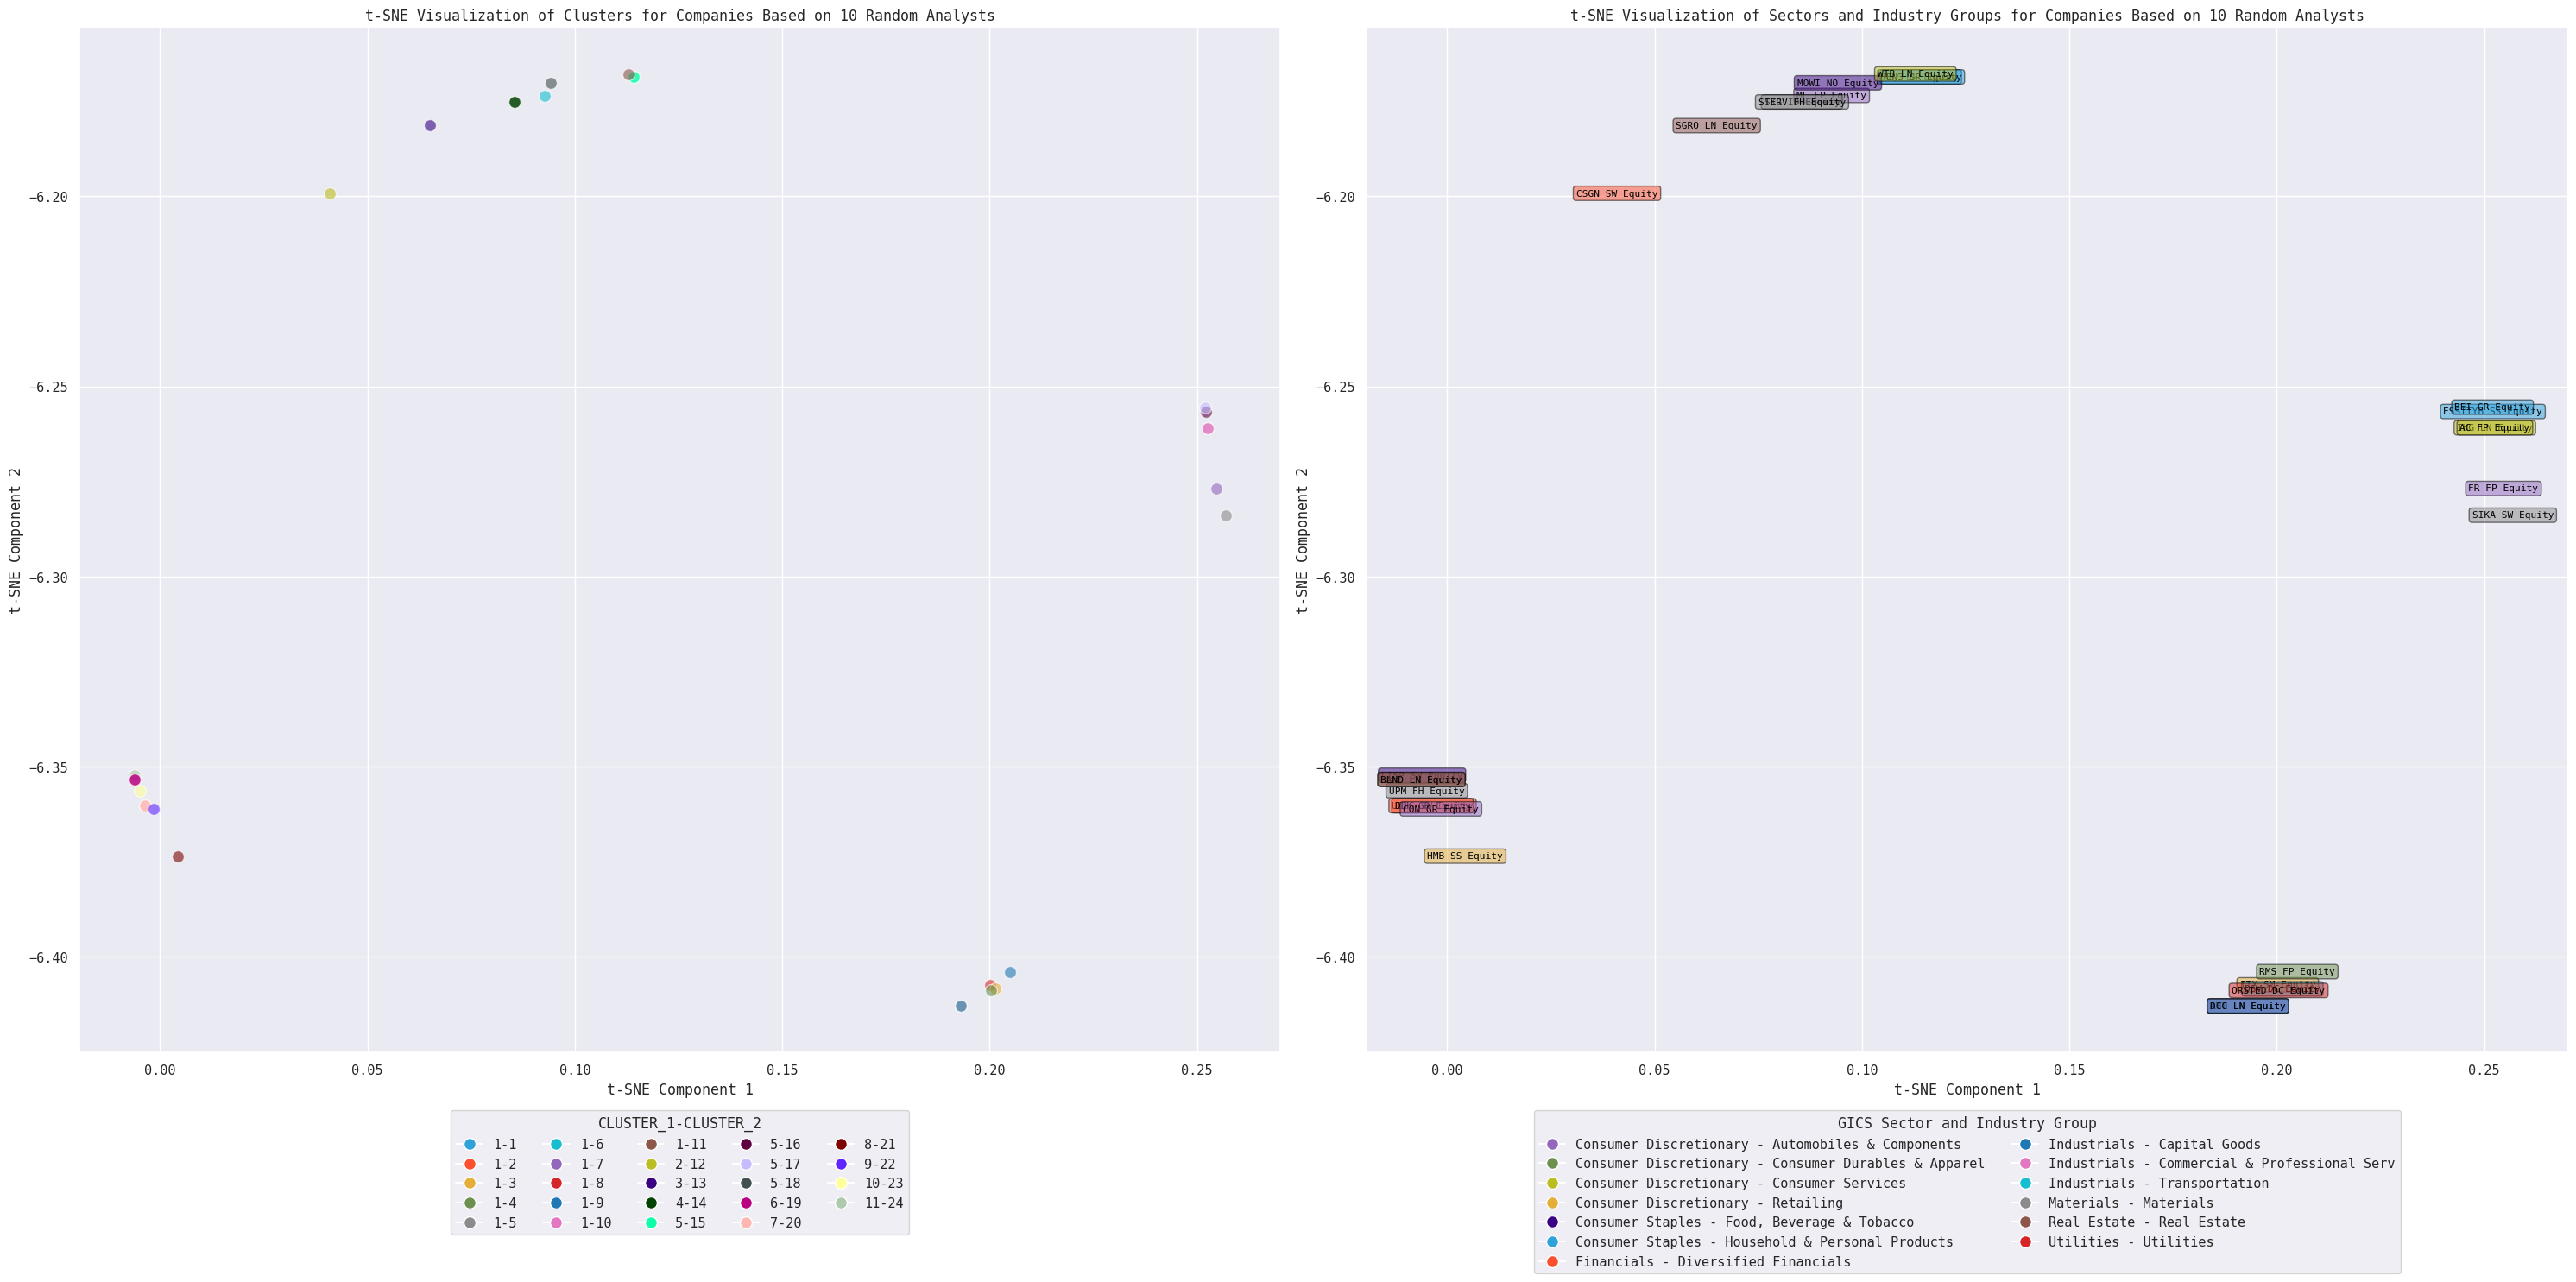

In [223]:
# Perform t-SNE
# Adjust perplexity value to be lower than dataset
n_samples = df_preprocessed_filtered2.shape[0]
perplexity_value = min(30, n_samples - 1)

tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=perplexity_value)
tsne_results = tsne.fit_transform(df_preprocessed_filtered2)

# Create a new DataFrame for the t-SNE results with cluster and sector information
df_tsne = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
df_tsne['CLUSTER_1'] = df_filtered2['CLUSTER_1']
df_tsne['CLUSTER_2'] = df_filtered2['CLUSTER_2']
df_tsne['COMBINED_CLASTER'] = df_tsne['CLUSTER_1'].astype(str) + "-" + df_tsne['CLUSTER_2'].astype(str)
df_tsne['GICS_SECTOR_NAME'] = df_filtered2['GICS_SECTOR_NAME']
df_tsne['GICS_INDUSTRY_GROUP_NAME'] = df_filtered2['GICS_INDUSTRY_GROUP_NAME']
df_tsne['COMPANY'] = df_filtered2['BBTICKER']

fig, axes = plt.subplots(1, 2, figsize=(30, 15))

# Plot t-SNE by combined clusters
combined_colormap_clusters = plt.get_cmap("cet_glasbey_hv")
unique_combinations_clusters = df_tsne[['CLUSTER_1', 'CLUSTER_2']].drop_duplicates().sort_values(by=['CLUSTER_1', 'CLUSTER_2'])
color_map_combined_clusters = {tuple(comb): combined_colormap_clusters(i) for i, comb in enumerate(unique_combinations_clusters.itertuples(index=False, name=None))}

for i in range(df_tsne.shape[0]):
    cluster_comb = (df_tsne['CLUSTER_1'].iloc[i], df_tsne['CLUSTER_2'].iloc[i])
    axes[0].scatter(
        df_tsne.TSNE1.iloc[i],
        df_tsne.TSNE2.iloc[i],
        color=color_map_combined_clusters[cluster_comb],
        s=100,
        edgecolor='w',
        alpha=0.6
    )

handles_combined_clusters = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map_combined_clusters[comb], markersize=10, label=f'{comb[0]}-{comb[1]}') for comb in sorted(color_map_combined_clusters.keys())]
axes[0].legend(handles=handles_combined_clusters, title='CLUSTER_1-CLUSTER_2', loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=5)

axes[0].set_title('t-SNE Visualization of Clusters for Companies Based on 10 Random Analysts')
axes[0].set_xlabel('t-SNE Component 1')
axes[0].set_ylabel('t-SNE Component 2')

# Plot t-SNE by GICS sectors and industry groups
combined_colormap = plt.get_cmap("cet_glasbey_hv")
unique_combinations = df_tsne[['GICS_SECTOR_NAME', 'GICS_INDUSTRY_GROUP_NAME']].drop_duplicates()
color_map_combined = {tuple(comb): combined_colormap(i) for i, comb in enumerate(unique_combinations.itertuples(index=False, name=None))}

for i in range(df_tsne.shape[0]):
    sector_industry_comb = (df_tsne['GICS_SECTOR_NAME'].iloc[i], df_tsne['GICS_INDUSTRY_GROUP_NAME'].iloc[i])
    axes[1].text(
        df_tsne.TSNE1.iloc[i],
        df_tsne.TSNE2.iloc[i],
        df_tsne.COMPANY.iloc[i],
        horizontalalignment='center',
        verticalalignment='center',
        size=8,
        color='black',
        bbox=dict(facecolor=color_map_combined[sector_industry_comb], alpha=0.5, boxstyle='round,pad=0.3', edgecolor='black')
    )

# Create the legend for sectors and industry groups
sorted_color_map_combined = dict(sorted(color_map_combined.items(), key=lambda item: item[0]))
handles_combined = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=sorted_color_map_combined[comb], markersize=10, label=f'{comb[0]} - {comb[1]}') for comb in sorted_color_map_combined]
axes[1].legend(handles=handles_combined, title='GICS Sector and Industry Group', loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)

axes[1].scatter(df_tsne['TSNE1'], df_tsne['TSNE2'], alpha=0.0)
axes[1].set_title('t-SNE Visualization of Sectors and Industry Groups for Companies Based on 10 Random Analysts')
axes[1].set_xlabel('t-SNE Component 1')
axes[1].set_ylabel('t-SNE Component 2')

plt.tight_layout()
plt.show()

NOTE: 30 samples based on 10 random analysts too few. Might have to redo 3c to find a larger filtered dataset for better clustering.